In [684]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

In [685]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


# AirBnb prices in San Francisco

## Introduction

Airbnb is famous company and is know worlwide. 

#### Problem
Airbnb has become very famous since its creation back in 2008. There is now a bunch of offers with very different prices. Airbnb price will most likely depends on its location so customers are likely to be interested to know which neighborhood is the most suitable for his wallet. There is also chances that some keyword in the name of the Airbnb will lead to higher prices. So customer will be interested to know what are the characteristic of the rents that impact its price. 
Currently on Airbnb website there is no restaurant proposal from a selected Airbnb while the most frequent question to the host is where can we have dinner? This project aim at answering those question.


## Data requirement

Data about the location, the price, reviews the name and the neighbourhood of the airbnbs are needed. Foursquare API will then be used for the latest part of the project.
Ratings data are hilgy desirable but are not available.

## Data aquisition and cleaning

Airbnb released a few years ago some of their collected data. Unfortunately ratins is missing from the current release of data.
Data Source: http://insideairbnb.com/get-the-data.html

In [686]:
url="http://data.insideairbnb.com/united-states/ca/san-francisco/2019-03-06/visualisations/listings.csv"
bnb=pd.read_csv(url)
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,958,"Bright, Modern Garden Unit - 1BR/1B",1169,Holly,NaN,Western Addition,37.76931,-122.43386,Entire home/apt,170,1,180,2019-02-17,1.54,1,64
1,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74511,-122.42102,Entire home/apt,235,30,111,2017-08-06,0.93,1,0
2,7918,A Friendly Room - UCSF/USF - San Francisco,21994,Aaron,NaN,Haight Ashbury,37.76669,-122.45250,Private room,65,32,17,2016-11-21,0.15,9,365
3,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.76487,-122.45183,Private room,65,32,8,2018-09-12,0.15,9,365
4,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.77525,-122.43637,Entire home/apt,785,7,27,2018-08-11,0.23,2,90


In [687]:
print('The size of the data frame is',bnb.shape) 

The size of the data frame is (7151, 16)


Some NaN value are visible from the data frame preview, especially in the "neighbourhood_group". NaN check on all dataframe is perfomed below:

In [688]:
bnb.isna().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               7151
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1377
reviews_per_month                 1377
calculated_host_listings_count       0
availability_365                     0
dtype: int64

From the above table, it can be deducted that all the neighbourhood_group column is NaN. After deleting this columns, the last_review and reviews_per_month will be cleaned:

In [689]:
bnb=bnb.drop('neighbourhood_group', 1)
bnb= bnb.dropna(axis = 0, how ='any')
bnbcl=bnb.drop(bnb[bnb.price==0].index)
bnbcl.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

There is no more NaN in the dataframe.

## Exploratory Data Analysis

### Top 5 neighbourhood for airbnbs

Let's have a look at the top 5 neighborhood with the largest count of airbnbs

In [690]:
df=bnbcl.groupby('neighbourhood').count()
df1=df.sort_values('id',ascending=False)
df1.rename(columns={'id':'count'}, inplace=True)
df1=df1['count'].to_frame()
df1=df1.reset_index()
df1.head()


,neighbourhood,count
0,Mission,605
1,Western Addition,465
2,Downtown/Civic Center,379
3,Castro/Upper Market,362
4,Bernal Heights,346


Text(0.5, 1.0, 'Percentage of airbnbs by neighbourhoud')

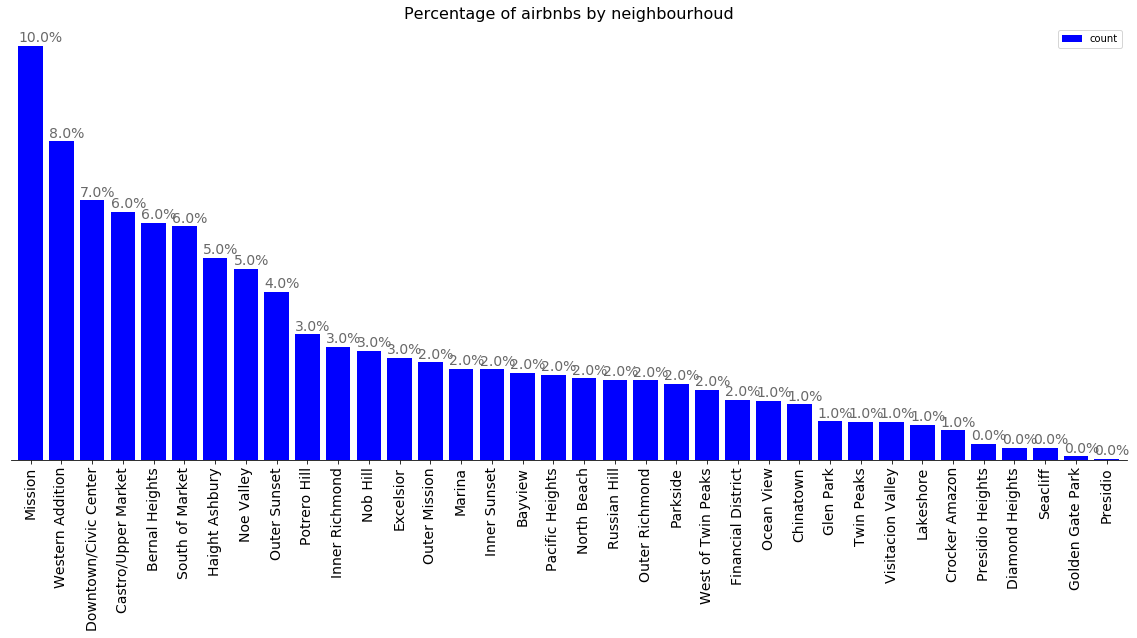

In [691]:
ax=df1.plot(kind='bar',figsize=(20, 8),color=['blue'],width=0.8)

#ax.legend(dff2.columns, fontsize=14)
ax.set_xticklabels(df1.neighbourhood, fontsize=14)
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none') 

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+6, \
                str(round((i.get_height()/5773)*100, 0))+'%', fontsize=14,
                color='dimgrey')
#ax.axes.get_yaxis().set_visible(True)
plt.xticks(fontsize=14)
#ax.grid(False)
ax.set_facecolor('white')
ax.set_title('Percentage of airbnbs by neighbourhoud',fontsize=16) # add title to the plot

Nice, but easier to see on the map so let's plot a choropleth of airbnbs in San Fransisco using geolocator to center the map to San Francisco.

In [692]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode('San Francisco,california')
sf_lat = location.latitude
sf_lng = location.longitude

# download San Francisco geojson file
!wget --quiet http://data.insideairbnb.com/united-states/ca/san-francisco/2019-03-06/visualisations/neighbourhoods.geojson -O sf.json

sf_geo = r'sf.json' # geojson file

# create a map
sf_map = folium.Map(location=[sf_lat,sf_lng], zoom_start=13)

# generate choropleth map 
sf_map.choropleth(
    geo_data=sf_geo,
    data=df1,
    columns=['neighbourhood','count'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', #YlGn
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Airbnb'
)

# display map
sf_map



## Top 5 most expensive neighbourhood for airbnbs

Now let's have a look on the price data:

In [693]:
bnbcl['price'].describe().to_frame()


,price
count,5773.000000
mean,210.628616
std,280.593587
min,10.000000
25%,99.000000
50%,150.000000
75%,240.000000
max,9000.000000


Let's plot the box plot for price:

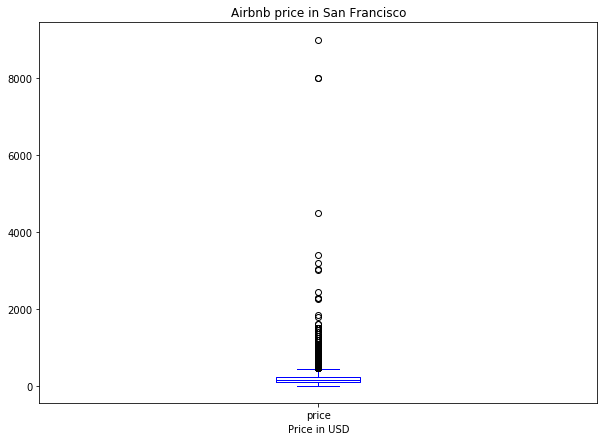

In [694]:
bnbcl['price'].plot(kind='box', figsize=(10, 7), color='blue')

plt.title('Airbnb price in San Francisco')
plt.xlabel('Price in USD')

plt.show()

From the box plot, many outliers can be observed. This is most likely due to the airbnb offers from cheap to luxurius rent. Let's get rid of the outliers and group the dataframe by neighbourhood:

In [714]:
q1price=bnbcl.price.quantile(0.25)
q3price=bnbcl.price.quantile(0.75)
iqrprice=q3price-q1price
limitprice=q3price+1.5*iqrprice
pricecl=bnbcl[bnbcl['price']< limitprice]
print ('the limit price/outlier:', limitprice,'USD')

the limit price/outlier: 451.5 USD


let's calculate average price by neighbourhood and get the 5 most expensive neighbourhood for airbnbs:

In [696]:
dff=pricecl.groupby('neighbourhood').mean()
dff1=dff.sort_values('price',ascending=False)
#dff1=dff1['count'].to_frame()
dff1=dff1.reset_index()
dff2 = dff1[['neighbourhood','price']]
dff2['price']=dff2['price'].astype(int)
dff2.head(5)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,neighbourhood,price
0,Russian Hill,204
1,Marina,203
2,Noe Valley,192
3,Castro/Upper Market,189
4,Diamond Heights,185


Text(0.5, 1.0, 'Average airbnb price by neighbourhood in USD')

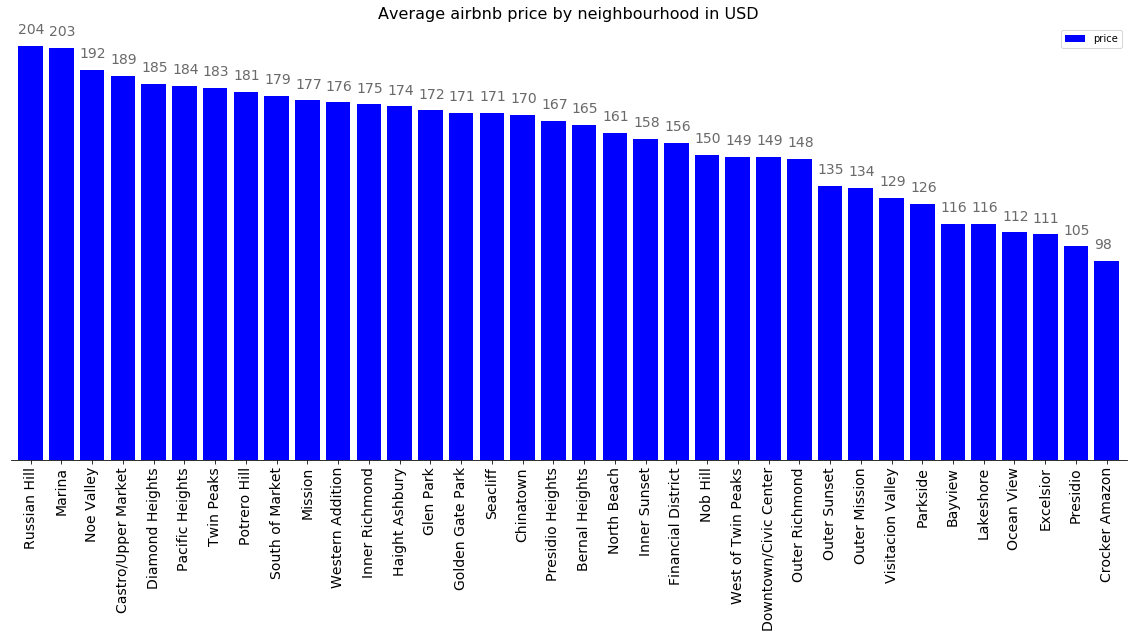

In [697]:
ax=dff2.plot(kind='bar',figsize=(20, 8),color=['blue'],width=0.8)

#ax.legend(dff2.columns, fontsize=14)
ax.set_xticklabels(dff2.neighbourhood, fontsize=14)
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none') 

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+6, \
            str(round((i.get_height()),0)), fontsize=14,
                color='dimgrey')
#ax.axes.get_yaxis().set_visible(True)
plt.xticks(fontsize=14)
#ax.grid(False)
ax.set_facecolor('white')
ax.set_title('Average airbnb price by neighbourhood in USD',fontsize=16) # add title to the plot

Let's plot this on the map now:

In [698]:
sf_map1 = folium.Map(location=[sf_lat,sf_lng], zoom_start=13)

# generate choropleth map 
sf_map1.choropleth(
    geo_data=sf_geo,
    data=dff2,
    columns=['neighbourhood','price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', #YlGn
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average airbnb price'
)

# display map
sf_map1


The two most expensive neighbourhoods for airbnbs are Russian Hill and Marina with respectively an average price of 204 and 203 USD per might. Russian Hill offers seems to offers great view on the San Francisco bay but you'll have to pay for it. As a comparison, the average price for the cheapest neighbourhoods is about 100 USD.

## Airbnb data versus price

Unfortumately the ratings are not available in the data set, but we can still check if there is a correlation between the price and the number of reviews for instance

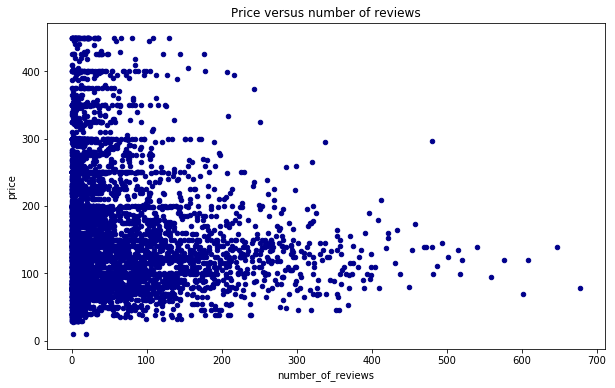

In [699]:
pricecl.plot(kind='scatter', x='number_of_reviews', y='price', figsize=(10, 6), color='darkblue')

plt.title('Price versus number of reviews')
plt.xlabel('number_of_reviews')
plt.ylabel('price')

plt.show()

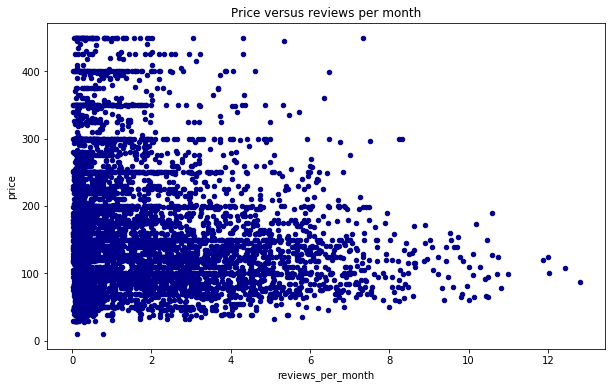

In [700]:
pricecl.plot(kind='scatter', x='reviews_per_month', y='price', figsize=(10, 6), color='darkblue')

plt.title('Price versus reviews per month')
plt.xlabel('reviews_per_month')
plt.ylabel('price')

plt.show()

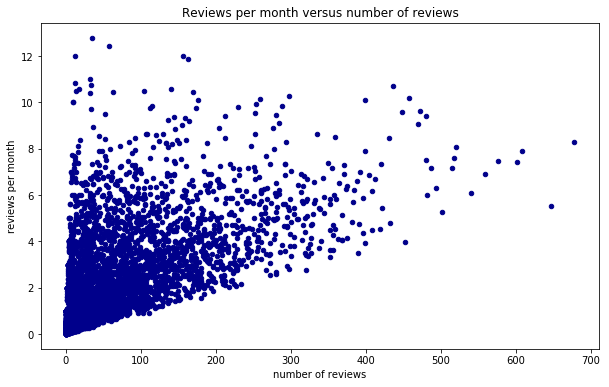

In [701]:
pricecl.plot(kind='scatter', x='number_of_reviews', y='reviews_per_month', figsize=(10, 6), color='darkblue')

plt.title('Reviews per month versus number of reviews')
plt.xlabel('number of reviews')
plt.ylabel('reviews per month')

plt.show()

It seems that the most expensive airbnbs get less reviews, but it is also likely that they have less customers...

In [702]:
!python -m pip install wordcloud

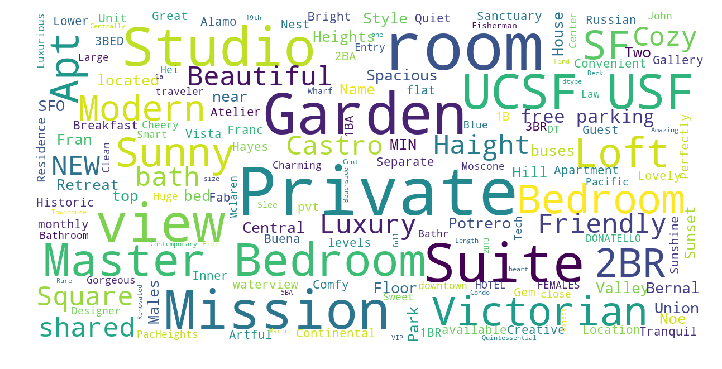

In [703]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


stopwords = set(STOPWORDS)
stopwords.add("San")
stopwords.add("Francisco")
stopwords.add("Home")
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(bnbcl['name'])


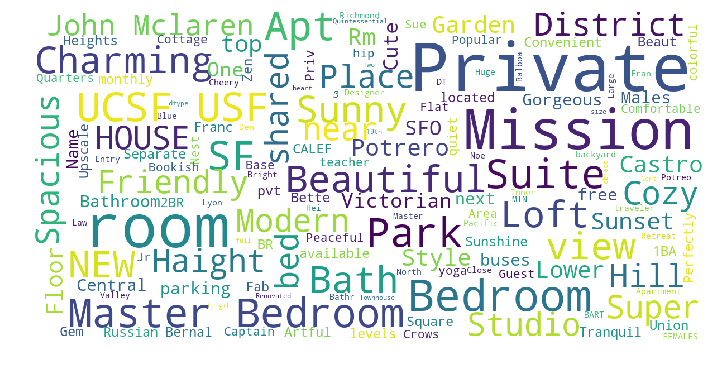

In [704]:
dff4=bnbcl[bnbcl['price']< 150]
show_wordcloud(dff4['name'])

Seems that for "cheap" airbnbs (<150 USD per night), the differenciator is that there is a private room but also proximity to Mission neighbourhood. Please note that luxury is not visible...

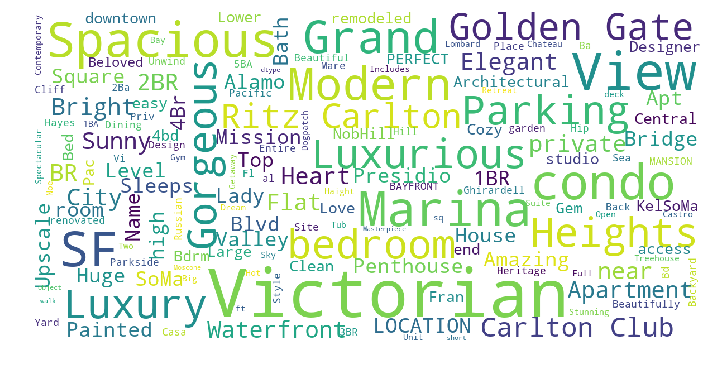

In [705]:
dff5=bnbcl[bnbcl['price']> 1000]
show_wordcloud(dff5['name'])

"Victorian" is the most frequent word that appears in the airbnb name with a price per night above 1000 USD. Victorian is the famous house style from San Francisco (use below link for picture). Also note that Marina also appears quite often which seems logical as it was one of the most expensive neighbourhood for airbnbs.
You can also note that luxury is well visible on the left side of the picture.

Link to Victorian style in San Francisco: https://www.tripsavvy.com/thmb/SrMWZ1cwOXNpkhsX4MXxkk9tTRE=/960x0/filters:no_upscale():max_bytes(150000):strip_icc()/victorian-houses-in-a-row-82302093-5851b9c75f9b586e026d42bd.jpg


## Quick look on the comments

In [706]:
dff3=pd.read_csv('http://data.insideairbnb.com/united-states/ca/san-francisco/2019-03-06/data/reviews.csv.gz')
dff3.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


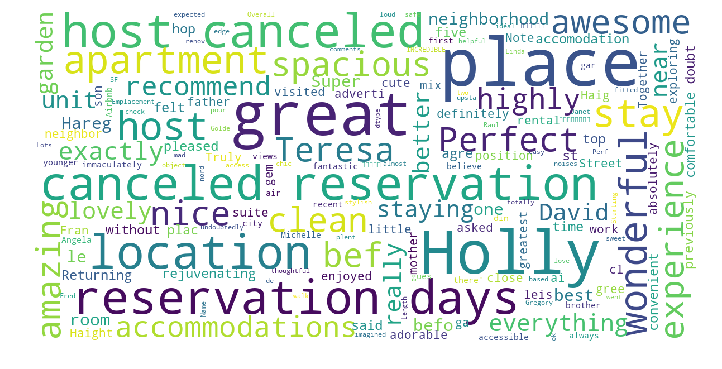

In [707]:
show_wordcloud(dff3['comments'])

Look like experience with airbnbs in San Francisco is mainly positive ;)

# Conclusion

In this report, we shown the impact of the location on the price of the airbnbs. We also shown that number of reviews and review per month are not good indicator for the price.
However, using the word cloud for two different sets of data, it is obvious that the name/description of the airbnb gives clues on the price we can expect.
For future work, the frequency of the world used in the description could be used (preprocessed by hot one encoding) to create clusters and to build a model to predict the price of the airbnbs.
Also, similar work could be done to evalute the rating given by customer from the world used in the comments.

# Also...

When I go to an airbnb I often arrive late and the first question to the host is: where can we find foooooodddd!!! Saddly on airbnb page, nothing is displayed about surrounding restaurant so let's repair this :

Let's take a random airbnb in San Francisco:

In [708]:
sample=bnbcl.sample()
sample=sample.loc[:, ['name','latitude', 'longitude']]

In [709]:
sample.head()

,name,latitude,longitude
2123,Large Castro 3 bedroom with Hot Tub :),37.75942,-122.44133


Extract latitude and longitude:

In [710]:
airbnb_latitude = sample.iloc[0]['latitude']
airbnb_longitude = sample.iloc[0]['longitude']

airbnb_name = sample.iloc[0,0] # airbnb name

print('Latitude and longitude values of {} are {}, {}.'.format(airbnb_name, 
                                                               airbnb_latitude, 
                                                               airbnb_longitude))

Latitude and longitude values of Large Castro 3 bedroom with Hot Tub :) are 37.75942, -122.44133000000001.


In [711]:
CLIENT_ID = 'P5XVRBZRK2X3UADAPS4NE3314WPJKJFJM3D54PPD5OIZOWWG' # your Foursquare ID
CLIENT_SECRET = 'QHCCHFK1L5ZDY1WHHOUQNMNP1R2YYWLLRXOJ01ZJE5Q0NB43' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

radius=500
LIMIT=100
url2 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, airbnb_latitude, airbnb_longitude, VERSION, radius, LIMIT)
url2

'https://api.foursquare.com/v2/venues/explore?client_id=P5XVRBZRK2X3UADAPS4NE3314WPJKJFJM3D54PPD5OIZOWWG&client_secret=QHCCHFK1L5ZDY1WHHOUQNMNP1R2YYWLLRXOJ01ZJE5Q0NB43&ll=37.75942,-122.44133000000001&v=20180605&radius=500&limit=100'

Get the point of interest, filter so it only show restaurants and calculate distance from the Airbnb

In [712]:
results = requests.get(url2).json()
results
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#Filter for food, restaurant, pizza

l = ['FOOD','RESTAURANT','PIZZA']  
regstr = '|'.join(l)
exp=nearby_venues[nearby_venues['categories'].str.upper().str.contains(regstr)]

##Def function to calculate distance from the airbnb
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

#Calculate distance
#conv from miles to meters
conv=1609,34
exp['distance (miles)'] = exp.apply(lambda row: haversine(airbnb_latitude,airbnb_longitude,row['lat'], row['lng']), axis=1)
exp['distance (meters)']=exp['distance (miles)']*1609
exp['distance (meters)']=exp['distance (meters)'].astype(int)
exp.head()



/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

,name,categories,lat,lng,distance (miles),distance (meters)
1,MaMa Ji's,Szechuan Restaurant,37.760750,-122.438651,0.172786,278
9,Takara Sushi,Japanese Restaurant,37.760811,-122.436774,0.266817,429
14,Firewood Café,New American Restaurant,37.760847,-122.436911,0.260771,419


In [713]:
# create map of with surrounding restaurant from the airbnb
rest = folium.Map(location=[airbnb_latitude, airbnb_longitude], zoom_start=16)

# add markers to map
for lat, lng, name, in zip(sample['latitude'], sample['longitude'], sample['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(rest)  
    
for lat, lng, name,categories,distance in zip(exp['lat'], exp['lng'], exp['name'], exp['categories'],exp['distance (meters)']):
    label = '{},{},dist:{}m'.format(name,categories,distance)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(rest)          
rest

Bon appétit :)